In [1]:
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb
import datetime

### Estacionariedad en los PE
### Proceso Estocástico Estacionario (PEE) → pdf no cambia con el tiempo
### Forma débil: cuando media y varianza no varían en el tiempo y la función de correlación sólo depende de la distancia temporal entre las v.a.
### Forma fuerte: determinar si las pdf cambian con el tiempo.
### De estudios preliminares surgió que:
### (1) La estacionariedad depende de la longitud de segmentos que se consideren
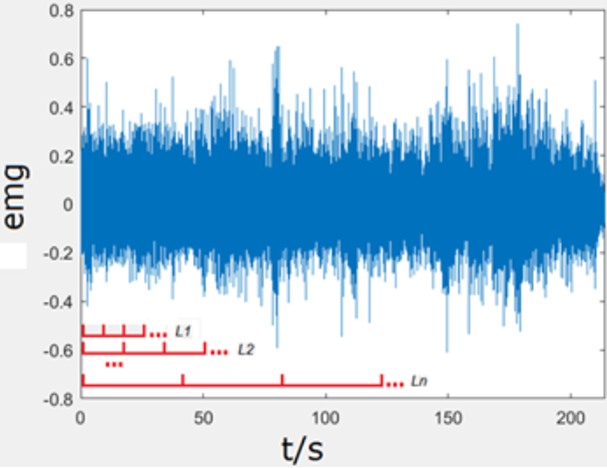

### (2) Las pdf depende fuertemente de la cantidad de datos con los que se construyen.
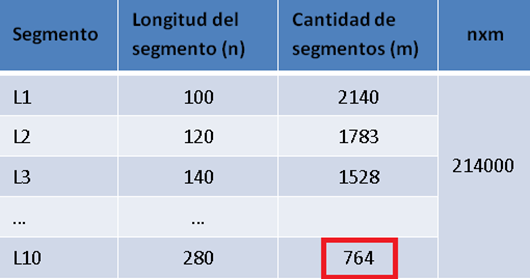

### Para cada longitud de segmento:
### (a) Transformar el vector de datos en una matriz de orden (nxm), donde n = longitud del segmento y m es la cantidad de segmentos para esa longitud.
### (b) De cada matriz elijo aleatoriamente 10 filas (10 instantes de tiempo) y son los datos con los que construir las 10 pdf.
### (c) Comparar las pdf empleando alguna métrica y definir algún criterio para decidir si las pdf se pueden considerar idénticas o no.
### Registro:
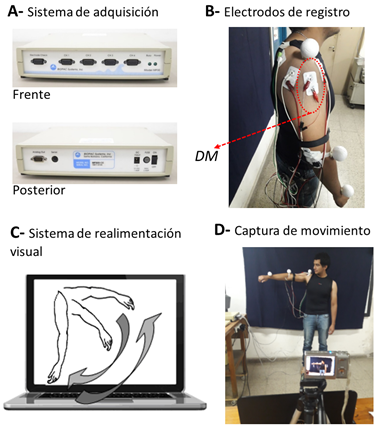

In [2]:
import bioread

In [3]:
data = bioread.read_file('V3-P0.acq')

In [4]:
data.channels

[Channel EMG (30 - 500 Hz) - DM: 96556 samples, 2000.0 samples/sec, loaded: True,
 Channel EMG (30 - 500 Hz) - DA: 96556 samples, 2000.0 samples/sec, loaded: True,
 Channel EMG (30 - 500 Hz) - DP: 96556 samples, 2000.0 samples/sec, loaded: True,
 Channel EMG (30 - 500 Hz) - TR: 96556 samples, 2000.0 samples/sec, loaded: True]

In [5]:
Fs = 2000
EMG = data.channels[0].data #selecciono los datos del músculo deltoides medio
nEMG = np.arange(len(EMG)); t = nEMG/Fs

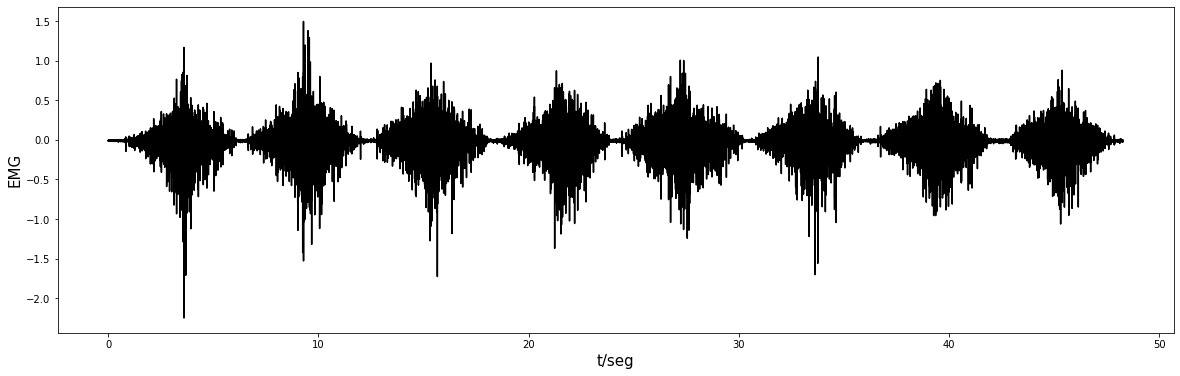

In [6]:
plt.figure(figsize=(20,6))
plt.plot(t, EMG, 'k')
plt.xlabel('t/seg', fontsize=15)
plt.ylabel('EMG', fontsize=15)
plt.show()

### Preprocesamiento de los datos: Eliminar las zonas donde no hay contracción muscular. Este proceso emplea la envolvente rms de la señal

In [7]:
from Función_envolvente_rms import envolvente_rms

importing Jupyter notebook from Función_envolvente_rms.ipynb


In [8]:
y = envolvente_rms(EMG,150)
ny = np.arange(len(y))

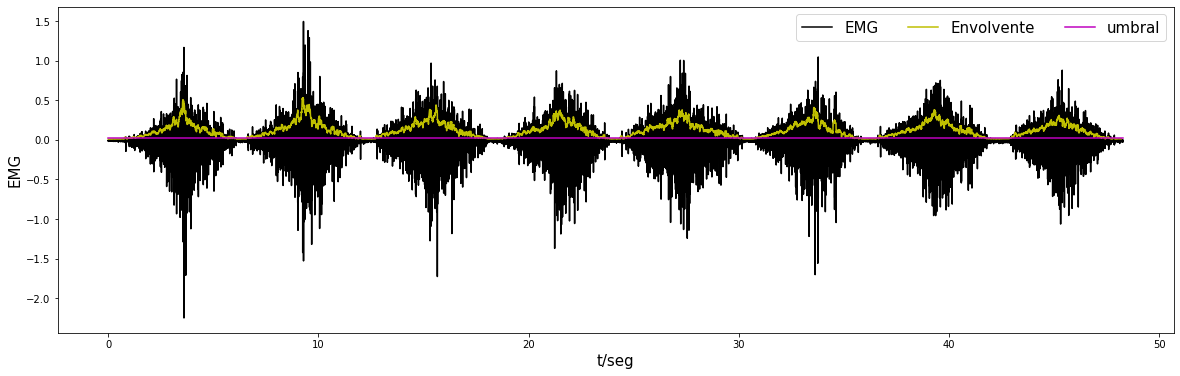

In [9]:
plt.figure(figsize=(20,6))
plt.plot(t, EMG, 'k')
plt.plot(ny/Fs,y,'y')
plt.plot([0,len(EMG)/Fs],[0.02,0.02],'m')
plt.legend(('EMG','Envolvente','umbral'),prop={'size':15},ncol=3,loc=0)
plt.xlabel('t/seg', fontsize=15)
plt.ylabel('EMG', fontsize=15)
plt.show()

In [10]:
from Función_para_eliminar_señal_por_debajo_de_un_umbral import EliminaConUmbral

importing Jupyter notebook from Función_para_eliminar_señal_por_debajo_de_un_umbral.ipynb


In [11]:
z = EliminaConUmbral(EMG, 0.02,150)

In [12]:
np.shape(z)

(3,)

In [13]:
k = z[0]; indices = z[1]; emg = z[2]
k, indices, emg

(27, array([ 1524.,  1677.,  1849., 11376., 11398., 11576., 11589., 11763.,
        11789., 11969., 13145., 13337., 13404., 23536., 23558., 23706.,
        23849., 24014., 25433., 35930., 37570., 37722., 37880., 46733.,
        46739., 47281., 47318., 47470., 48733., 48916., 49143., 59556.,
        59559., 59971., 60176., 60340., 61509., 61619., 61659., 71028.,
        71059., 71190., 71227., 71380., 73112., 73262., 73336., 83599.,
        85782., 94858., 95029., 95276., 95608., 95742.]), array([-0.01123047, -0.01550293, -0.0168457 , ...,  0.03393555,
         0.03637695,  0.03344727]))

In [14]:
emg_norm = (emg - np.mean(emg))/np.std(emg)
s = np.arange(len(emg_norm))

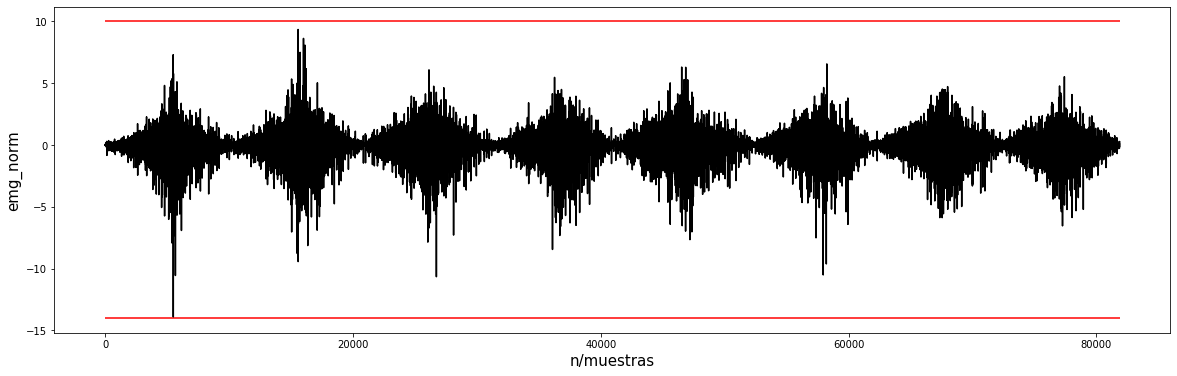

In [15]:
ylh = np.array([-14,10])
plt.figure(figsize=(20,6))
plt.plot(s, emg_norm, 'k')
plt.hlines(ylh,0,len(emg_norm),'r')
plt.xlabel('n/muestras', fontsize=15)
plt.ylabel('emg_norm', fontsize=15)
plt.show()

### (2) Segmentar la señal

In [16]:
n= np.arange(10,110,10)
seg = np.round(n) #vector de longitudes de segmento
nseg = len(seg)
seg, nseg

(array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100]), 10)

In [17]:
len(emg_norm)

81877

### (3) Para cada longitud de segmento construyo una matriz de datos. Elijo aleatoriamente 10 filas y construyo las 10 pdf

In [18]:
from Estimaciondeunafdp_new1 import pdf_new1

importing Jupyter notebook from Estimaciondeunafdp_new1.ipynb


In [62]:
tini = datetime.datetime.now()
bigp = np.empty(0); bigY = np.empty(0,dtype=float); dat = emg_norm; Ndat = len(dat)
x0, xf, Np = -11, 10, 24000; d = (xf-x0)/Np; x = x0 + d*np.arange(Np)
for i in np.arange(nseg): #este lazo recorre las diferentes longitudes de seg
    datos = np.empty((int(seg[i]),0)) # genero una matriz donde guardaré los datos
    m = Ndat//seg[i]
    aux = np.reshape(dat[0:seg[i]*m],(int(seg[i]),int(m)),order= 'F')
    datos = np.append(datos, aux, axis=1) #datos para cada longitud de seg
    mi = np.random.choice(int(m),818,replace=False)
    datos = datos[:,mi]
    r = np.random.choice(seg[i],10,replace=False) #elijo las 10 filas aleatoriamente
    p = datos[r,:]
    bigp = np.append(bigp, p)
    y1 = pdf_new1(p[0,:],x0,xf,Np,1); y2 = pdf_new1(p[1,:],x0,xf,Np,1)
    y3 = pdf_new1(p[2,:],x0,xf,Np,1); y4 = pdf_new1(p[3,:],x0,xf,Np,1)
    y5 = pdf_new1(p[4,:],x0,xf,Np,1); y6 = pdf_new1(p[5,:],x0,xf,Np,1)
    y7 = pdf_new1(p[6,:],x0,xf,Np,1); y8 = pdf_new1(p[7,:],x0,xf,Np,1)
    y9 = pdf_new1(p[8,:],x0,xf,Np,1); y10 = pdf_new1(p[9,:],x0,xf,Np,1)
    Y = np.hstack((y1,y2,y3,y4,y5,y6,y7,y8,y9,y10))
    bigY = np.append(bigY, Y)
tend =datetime.datetime.now()    

In [20]:
tend - tini

datetime.timedelta(seconds=195, microseconds=750921)

In [63]:
y1.shape, Y.shape, np.shape(bigY), Np * 10 * nseg

((24000,), (240000,), (2400000,), 2400000)

In [64]:
y = np.reshape(Y, (Np,10),order='F')

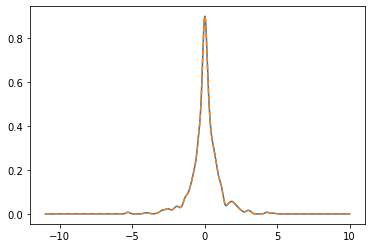

In [65]:
plt.plot(x,y[:,0])
plt.plot(x,y1,linestyle='--')
plt.show()

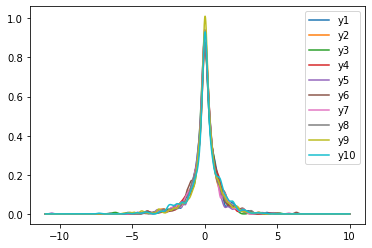

In [66]:
plt.plot(x,y)
plt.legend(('y1','y2','y3','y4','y5','y6','y7','y8','y9','y10'),prop={'size':10},ncol=1,loc=0)
plt.show()

In [67]:
Y1 = np.reshape(bigY,(Np, 10 * nseg), order='F')

In [68]:
Y1.shape

(24000, 100)

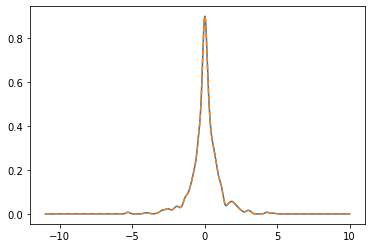

In [69]:
plt.plot(x,Y1[:,90])
plt.plot(x,y1,linestyle='--')
plt.show()

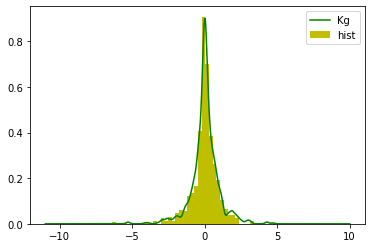

In [70]:
plt.plot(x,y1,'g')
plt.hist(p[2,:],bins=45,density=True,color='y')
plt.legend(('Kg','hist'))
plt.show()

### (1) ¿Que tan bueno es el ajuste de la pdf con kernel Gaussiano? y (2) ¿como comparamos las pdf?

In [29]:
from scipy.stats import norm, cauchy, gamma, logistic
from fitter import Fitter

,sumsquare_error,aic,bic,kl_div
cauchy,0.179472,792.839099,-6877.906526,inf
logistic,0.808751,1103.185655,-5646.431693,inf
norm,1.326410,1247.765091,-5241.734566,inf
gamma,1.396675,1261.629311,-5192.803525,inf


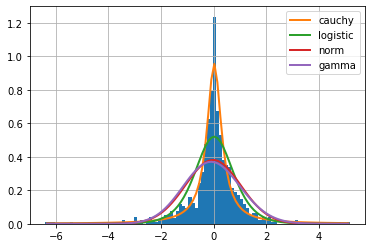

In [71]:
distribuciones = ['norm','cauchy','gamma','logistic']
fitter = Fitter(p[2,:],distributions=distribuciones)
fitter.fit()
fitter.summary(Nbest=4,plot=True)

### Cálculo de los parámetros de las distribuciones paramétricas:

In [72]:
fitter.fitted_param['cauchy']

(0.023996337030399613, 0.3333183334359089)

In [175]:
fitter.fitted_param['norm']

(-0.021634658787234556, 1.0463821828958062)

### La distribución de Cauchy tiene la forma:
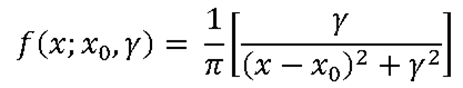

In [73]:
x_cauchy = x
y_cauchy = cauchy.pdf(x_cauchy, 0.023996337030399613, 0.3333183334359089)

In [176]:
x_norm = x
y_norm = norm.pdf(x_norm, -0.021634658787234556, 1.0463821828958062)

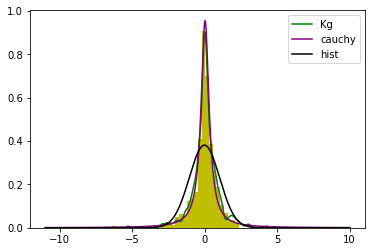

In [177]:
plt.plot(x,y1,'g')
plt.plot(x_cauchy,y_cauchy,'purple')
plt.plot(x_norm,y_norm,'k')
plt.hist(p[2,:],bins=45,density=True,color='y')
plt.legend(('Kg','cauchy','hist'))
plt.show()

### Sum of square error (sse)

In [34]:
from Sum_of_square_error_SSE import sse

importing Jupyter notebook from Sum_of_square_error_SSE.ipynb


In [75]:
H = np.histogram(p[0,:],bins=45,density=True)
yH = H[0]; xH = H[1][:-1]

In [76]:
sse_kG = sse(xH,yH,x,y1)
sse_kG

0.18442254402221922

In [77]:
sse_cauchy = sse(xH,yH,x_cauchy,y_cauchy)
sse_cauchy

0.2124184803920275

In [178]:
sse_norm = sse(xH,yH,x_norm,y_norm)
sse_norm

0.5752278716421853

    Distribución        SSE        Parámetros
    kG                  0.1844
    cauchy              0.2124     0.023996337030399613, 0.3333183334359089
    norm                0.5752     -0.021634658787234556, 1.0463821828958062
    ...

### Para responder a la segunda pregunta: ¿cómo hacemos para comparar las pdf's?
### (1)	Henry F. Inman & Edwin L. Bradley Jr (1989): The overlapping coefficient as a measure of agreement between probability distributions and point estimation of the overlap of two normal densities, Communications in Statistics - Theory and Methods, 18:10, 3851-3874.
### (2)	Distancia de Bhattacharyya
### (3)	Distancia de Wasserstein (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html)
### (4)	Empleando las curvas ROC

### Comparación entre las pdf:
### 1) Método del indice de solapamiento

In [78]:
from Overlapping_Index import area

importing Jupyter notebook from Overlapping_Index.ipynb


In [79]:
100/Fs

0.05

In [80]:
Area_50ms = np.empty(0)
for i in range(0,10):
    for j in range(i+1,10):
        Area_50ms = np.append(Area_50ms, area(x,y[:,i],y[:,j]))

In [81]:
len(Area_50ms)

45

In [82]:
from Factorial import factorial

importing Jupyter notebook from Factorial.ipynb


In [83]:
factorial(10)/(factorial(2)*factorial(10-2))

45.0

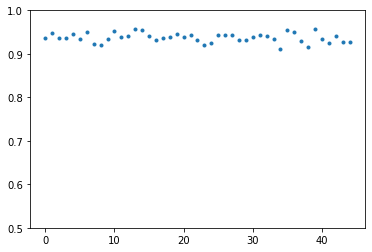

In [84]:
plt.plot(Area_50ms,'.')
plt.ylim(0.5,1)
plt.show()

### 2) Método de las curvas ROC

In [157]:
from Calculo_de_la_cdf_a_partir_de_la_pdf_Version1 import cdf
from Area_bajo_la_curva_ROC import AUC

In [153]:
y.shape

(24000, 10)

In [154]:
cdf1 = cdf(x,y[:,0]); cdf2 = cdf(x,y[:,1])

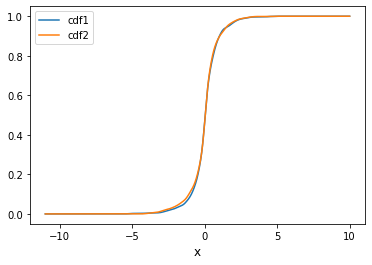

In [155]:
plt.plot(x,cdf1)
plt.plot(x,cdf2)
plt.xlabel('x',fontsize=12)
plt.legend(('cdf1','cdf2'),prop={'size':10},ncol=1,loc=0)
plt.show()

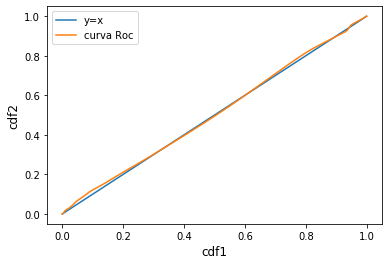

In [156]:
plt.plot(cdf1,cdf1)
plt.plot(cdf1,cdf2)
plt.xlabel('cdf1',fontsize=12)
plt.ylabel('cdf2',fontsize=12)
plt.legend(('y=x','curva Roc'),prop={'size':10},ncol=1,loc=0)
plt.show()

In [158]:
AUC(cdf1,cdf2)

0.49494618369999854

In [159]:
CDF = np.zeros((Np,10))
for i in range(10):
    CDF[:,i] = cdf(x,y[:,i])

In [160]:
CDF.shape

(24000, 10)

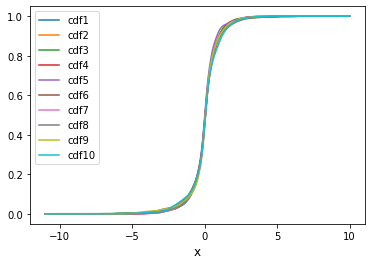

In [161]:
plt.plot(x,CDF)
plt.xlabel('x',fontsize=12)
plt.legend(('cdf1','cdf2','cdf3','cdf4','cdf5','cdf6','cdf7','cdf8','cdf9','cdf10'),
           prop={'size':10},ncol=1,loc=0)
plt.show()

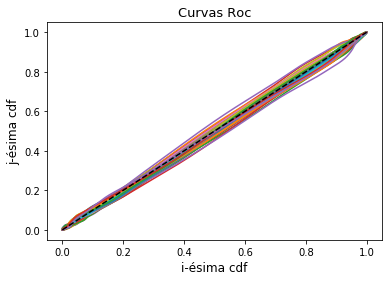

In [163]:
for i in range(0,10):
    for j in range(i+1,10):
        plt.plot(CDF[:,i],CDF[:,j])
plt.plot(cdf1,cdf1,'k',linestyle='--')
plt.title('Curvas Roc',fontsize=13)
plt.xlabel('i-ésima cdf',fontsize=12)
plt.ylabel('j-ésima cdf',fontsize=12)
plt.show()

In [164]:
Area_AUC = np.empty(0)
for i in range(0,10):
    for j in range(i+1,10):
        Area_AUC = np.append(Area_AUC, AUC(CDF[:,i],CDF[:,j]))

In [165]:
Area_AUC.shape

(45,)

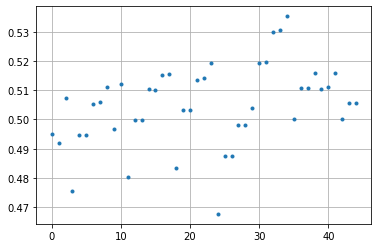

In [169]:
plt.plot(Area_AUC,'.')
#plt.ylim(0,1)
plt.grid(True)
plt.show()

### 3) Método de la distancia de Wasserstein (movimiento de tierra)

In [170]:
from scipy.stats import wasserstein_distance

In [171]:
wasserstein_distance(y[:,0],y[:,1],CDF[:,0],CDF[:,1])

0.0043012381137956255

In [172]:
W_distance = np.empty(0)
for i in range(0,10):
    for j in range(i+1,10):
        W_distance = np.append(W_distance, wasserstein_distance(y[:,i],y[:,j],CDF[:,i],CDF[:,j]))

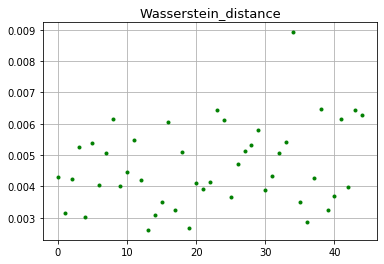

In [173]:
plt.plot(W_distance,'.',color='g')
plt.title('Wasserstein_distance',fontsize=13)
plt.grid(True)
plt.show()

In [174]:
wasserstein_distance(y[:,0],y[:,0],CDF[:,0],CDF[:,0])

0.0